# **CSE 7324 Lab 2: Exploring Image Data**
### *Thomas Adams, Suleiman Hijazeen, Nancy Le and Andrew Whigham*
------

### **1. Business Understanding**
------

### **2. Data Preparation**
------

In [1]:
# import dependencies

import sys
import os
from time import time
from time import sleep
from PIL import Image
import numpy as np
import pandas as pd


In [5]:
# helper functions to load and save images

def load_image(image):
    img = Image.open(image)
    img.load()
    npimage = np.asarray(img, dtype="int32")
    return npimage

def save_image(npimage, filename):
    img = Image.fromarray(np.asarray(np.clip(npimage, 0, 255), dtype="uint8"), "L")
    img.save(filename)

In [40]:
for root, dirs, files in os.walk('Data/Dataset/'):
    for file in files:
        pass

### **3. Data Reduction**
------

### **4. Feature Extraction with ORB Key Point Matching**
------

In [289]:
# dependencies
import os
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


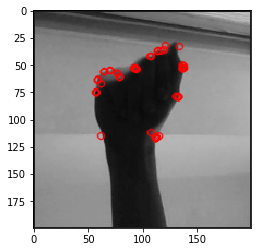

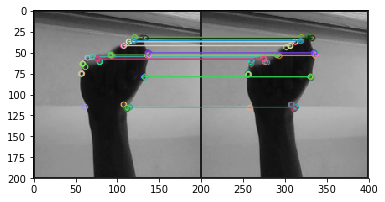

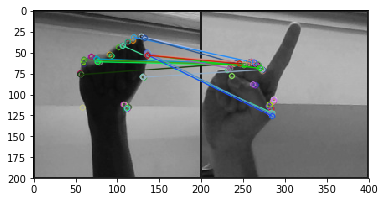

(<matplotlib.image.AxesImage at 0x7fec7d2758d0>, None)

In [290]:
%time

# initiate STAR Detector
orb = cv2.ORB_create()

# read in two images for ORB testing
img = cv2.imread('Data/asl_alphabet_train/A/A1.jpg', 0)
img2 = cv2.imread('Data/asl_alphabet_train/A/A2.jpg', 0)
img3 = cv2.imread('Data/asl_alphabet_train/Z/Z1.jpg', 0)

# find key points and compute descriptors
kp1, des1 = orb.detectAndCompute(img, None)
kp2, des2 = orb.detectAndCompute(img2, None)
kp3, des3 = orb.detectAndCompute(img3, None)

# draw keypoints location
kpimg = cv2.drawKeypoints(img, kp1, img, color=(255,0,0), flags=0)
plt.imshow(kpimg),plt.show()

# create brute force matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# match descripters computed for image 1 and 2 (same sign)
matches = bf.match(des1, des2)

# sort matches by distance
matches = sorted(matches, key=lambda x:x.distance)

# draw first 15 matches
img = cv2.drawMatches(img, kp1, img2, kp2, matches[:15], img, flags=0)
plt.imshow(img),plt.show()

# match descripter computed for image 2 and 3 (one with no sign)
matches2 = bf.match(des2, des3)
matches2 = sorted(matches, key=lambda x:x.distance)
img2 = cv2.drawMatches(img2, kp2, img3, kp3, matches[:15], img2, flags=0)
plt.imshow(img2),plt.show()

The above code is an example of using ORB to get the keypoints of an image and compare to other images. The second image shows the key points on two images of the same sign whereas the third picture shows the matching keypoints on different signs.

In [291]:
# helper function for sampling images for training
def sample_directories(num_samples, directory):
    file_sample = []
    target = []
    for root, dirs, files in os.walk(directory):
        for dir in dirs:
            for sample in random.sample(os.listdir(root+dir+'/'), num_samples):
                file_sample.append(root+dir+'/'+sample)
                target.append(dir)
    return file_sample, target

# training data
images, target = sample_directories(100, 'Data/asl_alphabet_train/')

print('I have {} images and {} targets in my training data'.format(len(images), len(target)))

# class to hold ORB keypoints and descriptors
class ImageORB:
    def __init__(self, img, kp, des):
        self.img = img
        self.kp = kp
        self.des = des
        
    def matches(self, des):
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        return bf.knnMatch(self.des, des, k=5)
    
    def getdes(self):
        return self.des
    
class ImageTest(ImageORB):
    def __init__(self, img, kp, des):
        super().__init__(img, kp, des)  
        
    def setDistance(self, distance):
        self.distance = distance
        
    def BestMatch(self, bestmatch):
        self.bestmatch = bestmatch

I have 2600 images and 2600 targets in my training data


The above code samples 100 images from each letter of the training data set and the corresponding target vector for the samples is generated. It also sets up and container class to hold all of the ORB keypoints and descriptors generated for each image.

In [292]:
# compute key points and descripters for each image

max_des_shape = 0

# training images
training_images = []
for image in images:
    img = cv2.imread(image, 0)
    kp, des = orb.detectAndCompute(img, None)
    if des.shape[0] * des.shape[1] > max_des_shape:
        max_des_shape = des.shape[0]*des.shape[1]
    training_images.append(ImageORB(img, kp, des))
    
# test images   
test_images = []
for root, dirs, files in os.walk('Data/asl_alphabet_test/'):
    for file in files:
        test_images.append(root+file)
       
test_img_objs = []
for test_img in test_images:
    img = cv2.imread(test_img, 0)
    kp, des = orb.detectAndCompute(img, None)
    if des.shape[0] * des.shape[1] > max_des_shape:
        max_des_shape = des.shape[0]*des.shape[1]
    test_img_objs.append(ImageTest(img, kp, des))

# build training set array
training_data = np.empty((1, max_des_shape), dtype=float)
# flatten all des and reshape into single row
for image in training_images:
    des = image.getdes()
    desf = des.flatten()
    despad = np.lib.pad(desf, (0, max_des_shape-desf.shape[0]), 'constant')
    desarr = np.array([despad])    
    training_data = np.vstack((training_data, desarr))

training_data = np.delete(training_data, 0, 0)
 
# build test set array
test_data = np.empty((1, max_des_shape), dtype=float)
for image in test_img_objs:
    des = image.getdes()
    desf = des.flatten()
    despad = np.lib.pad(desf, (0, max_des_shape-desf.shape[0]), 'constant')
    desarr = np.array([despad])    
    test_data = np.vstack((test_data, desarr))

test_data = np.delete(test_data, 0, 0)


The above code iterates through the training and test images and generates the key points and descriptors for each image. The descriptors are returned in an array in the shape of (Number of Key Points, 128). Because the number of key points varies between images, it was necessary to flatten and reshape the array into a single row of shape (1, max(number of keypoints) * 128) so that the array could be used with the KNN Classifier.

In [298]:
# use knn classifier to predict image
from sklearn.neighbors import KNeighborsClassifier
nn = KNeighborsClassifier(n_neighbors=3)
nn.fit(training_data, target)
predictions = nn.predict(test_data)

The reshaped array is used as the training set for the KNN Classifier and the target labels generated generated earlier are used for the target. The test data matrix generated earlier is then used to preict the sign displayed in the image. The number of neighbors was set to three as that seemed to maximize the accuracy of the prediction. Adjusting this up or down resulted in the accuracy dropping to ~23-25%.

In [299]:
# get labels from test image set
def gettestimagelabels():
    labels = []
    for image in test_images:
        labels.append(str.split(os.path.splitext(os.path.basename(image))[0], '_')[0])
    return labels

# compute accuracy
def calcpredictionaccuracy(predictions):
    matches = 0
    labels = gettestimagelabels()
    for i in range(len(labels)):
        if labels[i] == predictions[i]:
            matches+=1
    return matches/len(labels)
        
print('Accuracy of Predictor was {:0.2f}'.format(calcpredictionaccuracy(predictions)))

Accuracy of Predictor was 0.31


The accuracy of this classifier is terrible. This can be attributed ot the variance in the number of descriptors generated in the ORB feature detection. Overall, ORB is a good way of looking at similar features between sets of images, however, the KNN classifier is not a good classifer for images with features extracted in with ORB. Accuracy should be improved by using a brute force method.

In [300]:
# brute force classifier

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

predictions = []
for i in range(len(test_img_objs)):
    currentPrediction = ''
    currentMatches = []
    # large number to ensure it get updated
    currentMean = 10000
    for j in range(len(training_images)):
        matches = bf.match(test_img_objs[i].getdes(), training_images[j].getdes())
        matches = sorted(matches, key = lambda x:x.distance)
        if len(currentMatches) == 0:
            currentPrediction = target[j]
            currentMatches = matches
            msum = 0
            for match in matches:
                msum+=match.distance
            currentMean = msum/len(matches)
            continue
        # must be at least 15 matches
        elif len(matches) < 15:
            continue
        else:
            msum = 0
            for match in matches:
                msum+=match.distance
            mmean = msum/len(matches)
            if mmean < currentMean:
                currentPrediction = target[j]
                currentMatches = matches
                currentMean = mmean
    predictions.append(currentPrediction)
            
print('Accuracy of brute force method to find closest match: {:0.2f}'.format(calcpredictionaccuracy(predictions)))

Accuracy of brute force method to find closest match: 0.96


Using a brute force method for finding the closest match increased the accuracy of the predictions to 96%. Although this worked fairly well for a small dataset such as this one, this is not a scalable solution for large datasets.

### **5. References**
------